In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import skimage
import os
from sklearn.metrics import mean_squared_error
from skimage import data, img_as_float
from skimage.restoration import denoise_nl_means
from skimage.measure import compare_ssim as ssim
from random import shuffle
import math
from keras.models import model_from_json

from utilities import *
%matplotlib inline

Using TensorFlow backend.


In [6]:
from keras.layers import *
from keras.models import Model
from keras import regularizers
from keras import backend as K
from keras.callbacks import TensorBoard
from keras.layers.core import Lambda


In [7]:
def read_all_datasets():
    images = read_dataset('data/all-mias/')
    images.extend(read_dataset('data/dental'))
    images.extend(read_dataset('data/RawImage/TrainingData'))
    return np.array(images)

In [8]:
images = read_all_datasets()

In [9]:
print images.shape

(722, 64, 64)


In [10]:
#preprocessing
images = images.astype('float32')/255.
images = np.reshape(images, (images.shape[0],64,64,1))

In [11]:
print images.shape

(722, 64, 64, 1)


In [12]:
display_images(images,10)

RuntimeError: Could not create write struct

In [13]:
#Adding noise to images
def add_noise(images):
    #x_train = np.reshape(x_train, (len(x_train), 64*64))  # adapt this if using `channels_first` image data format
    #x_test = np.reshape(x_test, (len(x_test), 64*64))  # adapt this if using `channels_first` image data format
    batch = images.shape[0]/4;
    noise1 = gaussian_noise(images[0:batch],0,1,0.1)
    noise2 = gaussian_noise(images[batch:2*batch],0,1,0.5)
    noise3 = gaussian_noise(images[2*batch:3*batch],0,2,0.2)
    noise4 = gaussian_noise(images[3*batch:],0,3,0.1)
    
    noisy_set = []
    for data in [noise1,noise2,noise3,noise4]:
        for image in data:
            noisy_set.append(image)
    
    return np.array(noisy_set)
   
#Shuffle the noisy image ground truth pair to randomize the noise distribution in the dataset
def pair_shuffle(images,noisy_set):
    image_pair = []
    for i in range(images.shape[0]):
        image_pair.append((images[i],noisy_set[i]))
    shuffle(image_pair)
    
    ground_truth=[]
    noisy_images = []
    for i in range(images.shape[0]):
        ground_truth.append(image_pair[i][0])
        noisy_images.append(image_pair[i][1])
    return np.array(ground_truth), np.array(noisy_images)
    
    

In [14]:
#Shuffling and adding noise to the dataset
shuffle(images)
#Getting the noisy image set
noisy_set = add_noise(images)
ground_truth,noisy_images = pair_shuffle(images,noisy_set)

In [15]:
#Split into training and cross validation
train_size = int(ground_truth.shape[0]*0.8)
x_train = ground_truth[0:train_size]
x_train_noisy = noisy_images[0:train_size]
x_test = ground_truth[train_size:]
x_test_noisy = noisy_images[train_size:]
print x_train_noisy.shape
print x_test_noisy.shape

(577, 64, 64, 1)
(145, 64, 64, 1)


In [16]:
#Ground truth
display_images(ground_truth,10)

RuntimeError: Could not create write struct

In [17]:
#Noisy images
display_images(noisy_images,10)

RuntimeError: Could not create write struct

In [18]:
#Defining the model

def get_simple_autoencoder_model(model_path=None):
    
    if(model_path is None):
        autoencoder = None
    else:
        autoencoder = read_model_json(model_path) 
    
    if(autoencoder is None):
        input_img = Input(shape=x_train_noisy[0].shape)  # adapt this if using `channels_first` image data format

        x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
        x = MaxPooling2D((2, 2), padding='same')(x)
        x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        encoded = MaxPooling2D((2, 2), padding='same')(x)

        x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
        x = UpSampling2D((2, 2))(x)
        x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = UpSampling2D((2, 2))(x)
        decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

        autoencoder = Model(input_img, decoded)
        autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy',metrics = ['accuracy'])

    print autoencoder.summary()
    return autoencoder

In [20]:
#Training the model
autoencoder = get_simple_autoencoder_model()
autoencoder.fit(x_train_noisy, x_train,
                epochs=1,
                batch_size=10,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder', histogram_freq=0, write_graph=True)])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 64, 64)        640       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 32, 32, 64)        0         
__________

In [21]:
#Function to get saved keras model
def read_model_json(jsonfilePath,h5filePath):
    try:
        json_file = open(jsonfilePath, 'r')
        print json_file
        loaded_model_json = json_file.read()
        json_file.close()
        print "hello"
        loaded_model = model_from_json(loaded_model_json)
         
        # load weights into new model
        loaded_model.load_weights(h5filePath)

        return loaded_model
    except:
        return None


In [27]:
def get_gated_connections(gatePercentageFactor,inputLayer):
    gateFactor = Input(tensor = K.variable([gatePercentageFactor]))
    fractionG = Lambda(lambda x: x[0]*x[1])([inputLayer,gateFactor])
    complement = Lambda(lambda x: x[0] - x[1])([inputLayer,fractionG])
    
    return gateFactor,fractionG,complement

#x is conv layer
#y is de-conv layer
#gf is gating factor
#fg is fractional input from gate
#c is complement ie remaining fraction from the gate
#jt joining tensor of convolution layer and previous de-conv layer 

def get_cnn_dsc_architecture(model_path=None):
    
    if(model_path is None):
        model = None
    else:
        model = read_model_json(model_path[0],model_path[1])
        print model_path[0],model_path[1]
    if(model is None):
        input_img = Input(shape=(64,64,1))  # adapt this if using `channels_first` image data format
        x1 = Conv2D(64, (4, 4), activation='relu', padding='same')(input_img)
        gf1,fg1,c1 = get_gated_connections(0.1,x1)

        x = MaxPooling2D((2, 2), padding='same')(fg1)
        x2 = Conv2D(64, (4, 4), activation='relu', padding='same')(x) 
        gf2,fg2,c2 = get_gated_connections(0.2,x2)

        x = MaxPooling2D((2, 2), padding='same')(fg2)
        x3 = Conv2D(128, (4, 4), activation='relu', padding='same')(x) 
        gf3,fg3,c3 = get_gated_connections(0.3,x3)

        x = MaxPooling2D((2, 2), padding='same')(x3)
        x4 = Conv2D(256, (4, 4), activation='relu', padding='same')(x) 
        gf4,fg4,c4 = get_gated_connections(0.4,x4)

        x = MaxPooling2D((2, 2), padding='same')(x4)
        x5 = Conv2D(512, (4, 4), activation='relu', padding='same')(x) 

        x = UpSampling2D((2, 2))(x5)
        y1 = Conv2DTranspose(256, (4, 4), activation='relu', padding='same')(x) 
        jt4 = Add()([y1,c4])
        x = UpSampling2D((2, 2))(jt4)

        y2 = Conv2DTranspose(128, (4, 4), activation='relu', padding='same')(x) 
        jt3 = Add()([y2,c3])
        x = UpSampling2D((2, 2))(jt3)

        y3 = Conv2DTranspose(64, (4, 4), activation='relu', padding='same')(x) 
        jt2 = Add()([y3,c2])
        x = UpSampling2D((2, 2))(jt2)

        jt1 = Add()([x,c1])
        y4 = Conv2DTranspose(64, (4, 4), activation='relu', padding='same')(jt1)
        y5 = Conv2DTranspose(1, (4, 4), activation='relu', padding='same')(y4) 

        layers = y5

        model = Model([input_img,gf1,gf2,gf3,gf4],layers)
        model.compile(optimizer='sgd', loss = 'mean_squared_error', metrics = ['accuracy'])
        print "Model created"
    else:
        print "Saved model loaded"
    print model.summary()
    return model

In [28]:
model = get_cnn_dsc_architecture(("models/CNNDSC.json","models/CNNDSC.h5"))

<open file 'models/CNNDSC.json', mode 'r' at 0x7fbc876cb780>
hello
models/CNNDSC.json models/CNNDSC.h5
Saved model loaded
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 64, 64, 1)     0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 64, 64, 64)    1088        input_1[0][0]                    
____________________________________________________________________________________________________
input_2 (InputLayer)             (1,)                  0                                            
____________________________________________________________________________________________________
lambda_1 (Lambda)                (None, 64, 64, 64)    0           con

In [29]:
model.fit(x_train_noisy, x_train,
                epochs=1,
                batch_size=10,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder', histogram_freq=0, write_graph=True)])

RuntimeError: You must compile a model before training/testing. Use `model.compile(optimizer, loss)`.

In [30]:
save_model_as_json(model,'CNNDSC')


In [30]:
#Getting images to test
def get_testing_images(filePath):
    test_images = read_dataset(filePath)
    test_images = np.array(test_images)
    test_images = test_images.astype('float32')/255.
    test_images = np.reshape(test_images, (test_images.shape[0],64,64,1))
    noisy_test_images = add_noise(test_images)
    print noisy_test_images.shape
    return test_images,noisy_test_images

In [32]:
test_images,noisy_test_images = get_testing_images('data/Test/')

(120, 64, 64, 1)


In [33]:
noisy_test_images.shape

(120, 64, 64, 1)

In [2]:
noisy_test_images.shape

NameError: name 'noisy_test_images' is not defined

In [21]:
#Denoising using CNN Architecture
out = model.predict(noisy_test_images,verbose=1)
print out.shape

120/120 [==============================] - 5s     
(120, 64, 64, 1)


In [23]:
#Denoising using Autoencoders
out = autoencoder.predict(noisy_test_images,verbose=1)
print out.shape

NameError: name 'autoencoder' is not defined

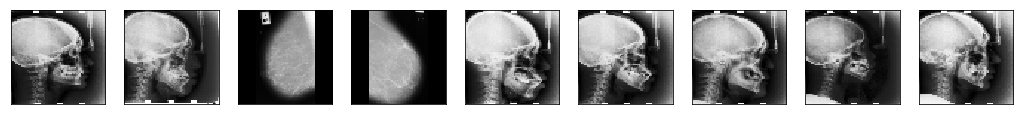

In [47]:
display_images(test_images,10)

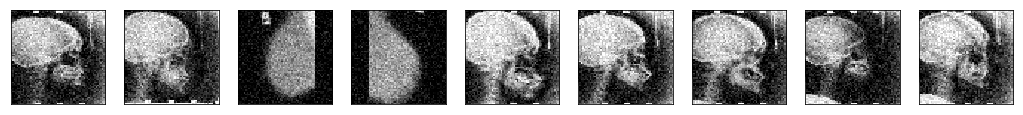

In [49]:
display_images(noisy_test_images,10)

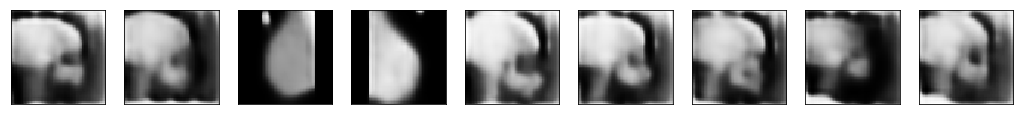

In [50]:
display_images(out,10)

In [23]:
def get_psnr_result(x_test, out):
    psnr_sum = 0
    for i in range(out.shape[0]):
        psnr_sum += get_psnr(x_test[i].reshape(64,64),out[i].reshape(64,64))
    return 1.0*psnr_sum/out.shape[0];

def get_ssim_result(originalSet,noisySet):
    ssim_sum = 0
    originalSet = originalSet.reshape(originalSet.shape[0],64,64)
    noisySet = noisySet.reshape(noisySet.shape[0],64,64)
    for i in range(originalSet.shape[0]):
        ssim_sum += ssim(originalSet[i], noisySet[i],data_range=originalSet[i].max() - noisySet[i].min())
    return 1.0*ssim_sum/originalSet.shape[0]


In [24]:
def bm3d_denoise(noisy_image):
    noisy_image = noisy_image.reshape(noisy_image.shape[0],64,64)
    noisy_image = noisy_image*255.0
    denoised = []
    for i in range(noisy_image.shape[0]):
        Basic_img = bm3d.BM3D_1st_step(noisy_image[i])
        Final_img = bm3d.BM3D_2nd_step(Basic_img, noisy_image[i])
        denoised.append(Final_img)
        print "Image " + str(i) + " denoised"
    return np.array(denoised)

In [28]:
def nlm_denoise(noisy_image):
    noisy_image = noisy_image.reshape(noisy_image.shape[0],64,64)
    noisy_image = noisy_image*255.0
    denoised = []
    
    for image in noisy_image:
        denoised_image = denoise_nl_means(image, 7, 11, 0.5)
        denoised.append(denoised_image)
        
    return np.array(denoised)

In [25]:
get_psnr_result(out,test_images)

18.058925031397493

In [33]:
import bm3d

In [34]:
print noisy_test_images.shape
bm3d_out = bm3d_denoise(noisy_test_images)

(120, 64, 64, 1)
Image 0 denoised
Image 1 denoised
Image 2 denoised
Image 3 denoised


KeyboardInterrupt: 

In [62]:
bm3d_out_norm = bm3d_out.astype('float32')/255.0

In [109]:
get_psnr_result(bm3d_out_norm,test_images)

17.682307569954464

In [129]:
nlm_out = nlm_denoise(noisy_test_images)
nlm_out = nlm_out.astype('float32')/255.0

In [130]:
get_psnr_result(nlm_out,test_images)

13.158936937288832

In [28]:
get_ssim_result(test_images,out)

0.55326809290886048

In [68]:
get_ssim_result(test_images,bm3d_out_norm)

0.48066831613812011

In [69]:
get_ssim_result(test_images,nlm_out)

0.28520212804943185

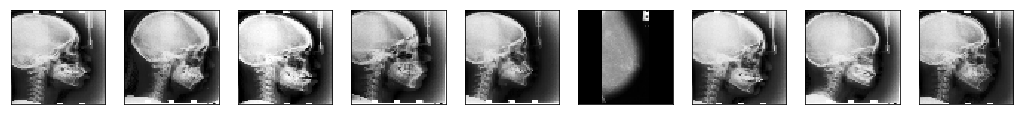

In [99]:
#Ground Truth
display_images(test_images,10)

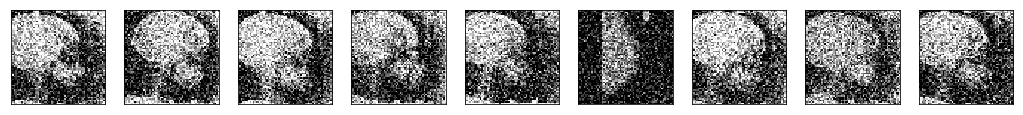

In [100]:
#Noisy images
display_images(noisy_test_images,10)

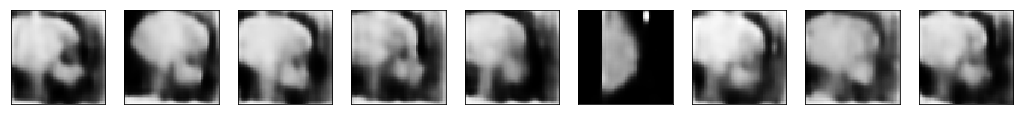

In [101]:
#Autoencoder denoised images
display_images(out,10)

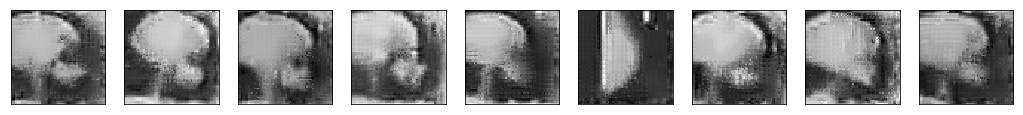

In [102]:
#bm3d denoised images
display_images(bm3d_out_norm,10)

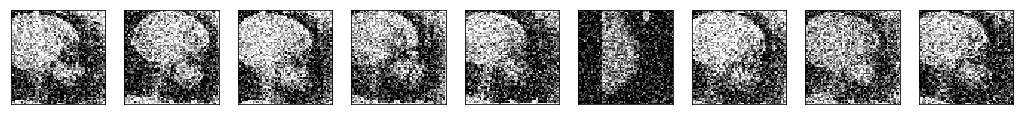

In [125]:
#nlm denoised images
display_images(nlm_out,10)